In [1]:
#import libraries
!pip install pymannkendall 
!pip install scikit-learn
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import pymannkendall as mk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import data and have a quick preview

In [2]:
# Read CSV, skipping the first 8 metadata rows
df = pl.read_csv(
    "data/Kenya_g4.areaAvgTimeSeries.MYD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean.20030101-20221231.180W_90S_180E_90N.csv",
    skip_rows=8
)
df

time,mean_MYD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean
str,str
"""1/1/2003""","""0.179891528"""
"""1/2/2003""","""0.17568374"""
"""1/3/2003""","""0.186048612"""
"""1/4/2003""","""0.184421713"""
"""1/5/2003""","""0.139056109"""
…,…
"""12/27/2022""","""0.29420671"""
"""12/28/2022""","""0.13232686"""
"""12/29/2022""","""0.102016834"""


In [ ]:
we notice data has #NAME? values,-9999 data for missing data

In [3]:
# Replace any unwanted characters (like extra spaces or symbols) in the 'time' column
df = df.with_columns(
    pl.col("time").str.replace(r"\s+", "").alias("time_clean")  # Remove all whitespace
)

#  Manually clean problematic entries like '#NAME?' or empty strings
df = df.with_columns(
    pl.when(pl.col("time_clean").is_in(["#NAME?", ""]))  # Handle invalid entries
    .then(None)
    .otherwise(pl.col("time_clean"))
    .alias("time_clean")
)

# Try to parse the cleaned time column (format: mm/dd/yyyy)
df = df.with_columns(
    pl.col("time_clean")
    .str.strptime(pl.Datetime, "%m/%d/%Y")  # Parsing the date in m/d/yyyy format
    .alias("date_parsed")  # Store the parsed date in a new column
)

In [4]:
#drop "#NAME?" values
df = df.with_columns(
    pl.when(pl.col(df.columns[1]) == "#NAME?")  # Check if value is "#NAME?"
    .then(None)  # Replace with None
    .otherwise(pl.col(df.columns[1]))  # Keep the original value if it's not "#NAME?"
    .cast(pl.Float64)  # Convert the column to Float64
    .alias("aod")  # Rename the column to 'aod'
)



df

time,mean_MYD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean,time_clean,date_parsed,aod
str,str,str,datetime[μs],f64
"""1/1/2003""","""0.179891528""","""1/1/2003""",2003-01-01 00:00:00,0.179892
"""1/2/2003""","""0.17568374""","""1/2/2003""",2003-01-02 00:00:00,0.175684
"""1/3/2003""","""0.186048612""","""1/3/2003""",2003-01-03 00:00:00,0.186049
"""1/4/2003""","""0.184421713""","""1/4/2003""",2003-01-04 00:00:00,0.184422
"""1/5/2003""","""0.139056109""","""1/5/2003""",2003-01-05 00:00:00,0.139056
…,…,…,…,…
"""12/27/2022""","""0.29420671""","""12/27/2022""",2022-12-27 00:00:00,0.294207
"""12/28/2022""","""0.13232686""","""12/28/2022""",2022-12-28 00:00:00,0.132327
"""12/29/2022""","""0.102016834""","""12/29/2022""",2022-12-29 00:00:00,0.102017


In [5]:
#Identify numeric columns
numeric_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in [pl.Int64, pl.Int32, pl.Float64, pl.Float32]]

#Filter out rows where any numeric column has -9999
df = df.filter(~pl.any_horizontal([pl.col(col) == -9999 for col in numeric_cols]))
df

time,mean_MYD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean,time_clean,date_parsed,aod
str,str,str,datetime[μs],f64
"""1/1/2003""","""0.179891528""","""1/1/2003""",2003-01-01 00:00:00,0.179892
"""1/2/2003""","""0.17568374""","""1/2/2003""",2003-01-02 00:00:00,0.175684
"""1/3/2003""","""0.186048612""","""1/3/2003""",2003-01-03 00:00:00,0.186049
"""1/4/2003""","""0.184421713""","""1/4/2003""",2003-01-04 00:00:00,0.184422
"""1/5/2003""","""0.139056109""","""1/5/2003""",2003-01-05 00:00:00,0.139056
…,…,…,…,…
"""12/27/2022""","""0.29420671""","""12/27/2022""",2022-12-27 00:00:00,0.294207
"""12/28/2022""","""0.13232686""","""12/28/2022""",2022-12-28 00:00:00,0.132327
"""12/29/2022""","""0.102016834""","""12/29/2022""",2022-12-29 00:00:00,0.102017


In [6]:


# Aggregate monthly average
monthly_avg = (
    df.lazy()
    .group_by_dynamic(index_column="date_parsed", every="1mo", period="1mo", closed="left")
    .agg([pl.col("aod").mean().alias("monthly_avg_aod")])
    .sort("date_parsed")
    .collect()
)

# Show the result
print(monthly_avg.head())

shape: (5, 2)
┌─────────────────────┬─────────────────┐
│ date_parsed         ┆ monthly_avg_aod │
│ ---                 ┆ ---             │
│ datetime[μs]        ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 2003-01-01 00:00:00 ┆ 0.117669        │
│ 2003-02-01 00:00:00 ┆ 0.127408        │
│ 2003-03-01 00:00:00 ┆ 0.125664        │
│ 2003-04-01 00:00:00 ┆ 0.130051        │
│ 2003-05-01 00:00:00 ┆ 0.160497        │
└─────────────────────┴─────────────────┘


In [39]:
!pip install pymannkendall

In [8]:
import pandas as pd
import pymannkendall as mk

# Run Mann-Kendall test
result_mk = mk.original_test(monthly_avg["monthly_avg_aod"])

# Create a DataFrame to display results in a table
mk_results_df = pd.DataFrame({
    "Test Statistic": [result_mk.Tau],
    "p-value": [result_mk.p],
    "Trend": [result_mk.trend],
    "H (Reject H0?)": [result_mk.h],
    "Variance": [result_mk.var_s],
    "Slope": [result_mk.slope],
    "Intercept": [result_mk.intercept]
})

# Display the tabular output
print("Mann-Kendall Test on Monthly AOD:")
print(mk_results_df.to_string(index=False))


Mann-Kendall Test on Monthly AOD:
 Test Statistic  p-value      Trend  H (Reject H0?)     Variance    Slope  Intercept
       0.159902 0.000226 increasing            True 1.545533e+06 0.000151   0.141693


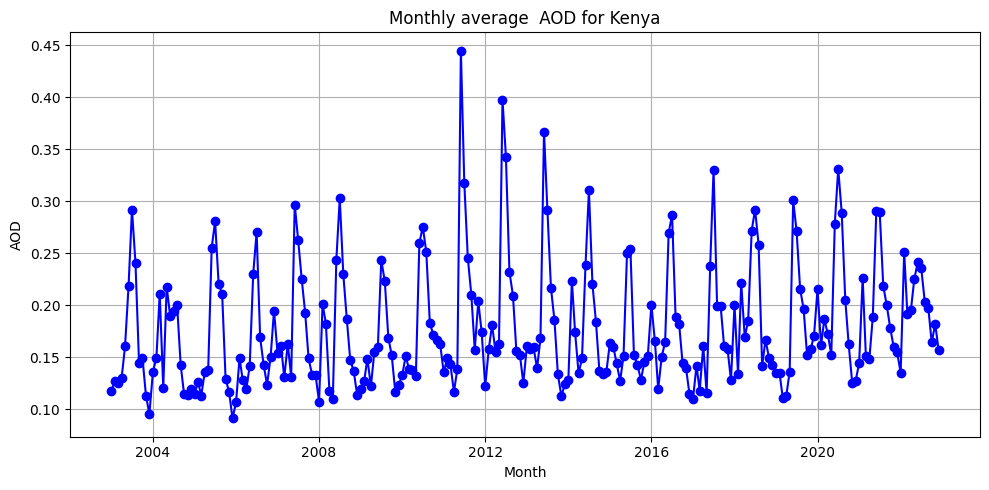

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg["date_parsed"], monthly_avg["monthly_avg_aod"], marker='o', color="blue")
plt.xlabel("Month")
plt.ylabel("AOD")
plt.title("Monthly average  AOD for Kenya")
plt.grid(True)
plt.tight_layout()
plt.show()

Training Set Performance:
RMSE: 0.0909, MAE: 0.0674, R²: 0.0080
Test Set Performance:
RMSE: 0.0867, MAE: 0.0668, R²: 0.0032


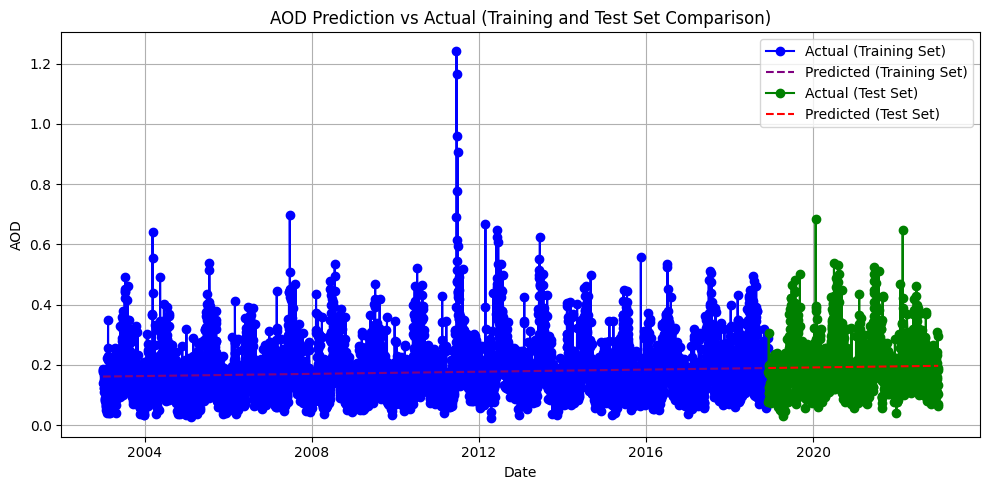

In [9]:
# Prepare features and target
X_dates = df["date_parsed"].to_numpy()  # Keep dates for plotting
X = X_dates.astype('datetime64[D]').astype(int).reshape(-1, 1)  # Convert to ordinal integers for model
y = df["aod"].to_numpy()

# Step 2: Train-test split
X_train, X_test, y_train, y_test, X_dates_train, X_dates_test = train_test_split(
    X, y, X_dates, shuffle=False, test_size=0.2
)

# Step 3: Fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict on training set and test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Step 5: Evaluate model performance on training set and test set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Set Performance:")
print(f"RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")

print(f"Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Step 6: Visualization with real dates
plt.figure(figsize=(10, 5))
plt.plot(X_dates_train, y_train, label="Actual (Training Set)", marker='o', color="blue")
plt.plot(X_dates_train, y_train_pred, label="Predicted (Training Set)", linestyle='--', color="purple")
plt.plot(X_dates_test, y_test, label="Actual (Test Set)", marker='o', color="green")
plt.plot(X_dates_test, y_test_pred, label="Predicted (Test Set)", linestyle='--', color="red")

plt.xlabel("Date")
plt.ylabel("AOD")
plt.title("AOD Prediction vs Actual (Training and Test Set Comparison)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Convert to LazyFrame and aggregate annually
annual_avg = (
    df.lazy()
    .group_by_dynamic(index_column="date_parsed", every="1y", period="1y", closed="left")
    .agg([
        pl.col("aod").mean().alias("annual_avg_aod")
    ])
    .sort("date_parsed")
    .collect()
)

# Show result
print(annual_avg.head())


shape: (5, 2)
┌─────────────────────┬────────────────┐
│ date_parsed         ┆ annual_avg_aod │
│ ---                 ┆ ---            │
│ datetime[μs]        ┆ f64            │
╞═════════════════════╪════════════════╡
│ 2003-01-01 00:00:00 ┆ 0.160121       │
│ 2004-01-01 00:00:00 ┆ 0.159363       │
│ 2005-01-01 00:00:00 ┆ 0.161143       │
│ 2006-01-01 00:00:00 ┆ 0.16014        │
│ 2007-01-01 00:00:00 ┆ 0.177107       │
└─────────────────────┴────────────────┘


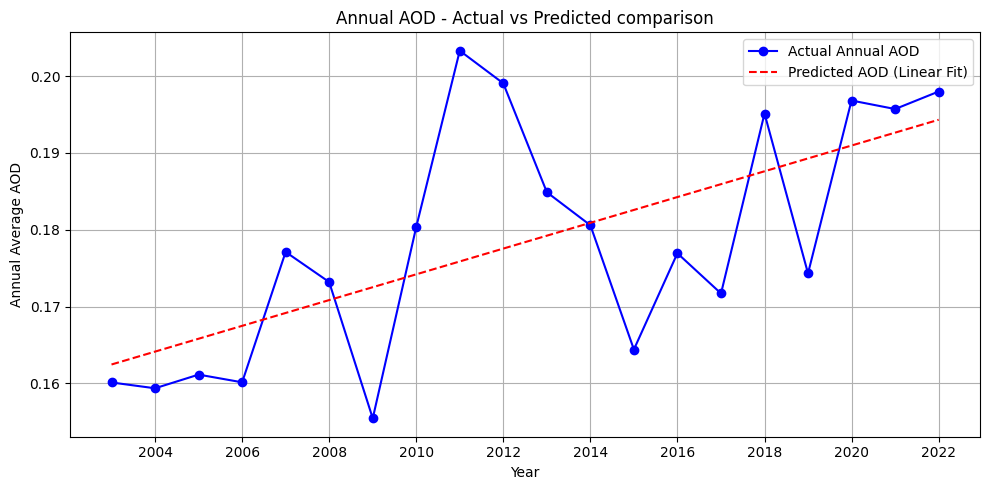

In [11]:
# Prepare features and target
X_dates = annual_avg["date_parsed"].to_numpy()
X = X_dates.astype("datetime64[D]").astype("int64").reshape(-1, 1)
y = annual_avg["annual_avg_aod"].to_numpy()

# Train-test split 
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot the full dataset with model prediction
plt.figure(figsize=(10, 5))
plt.plot(X_dates, y, label="Actual Annual AOD", marker='o', color="blue")
plt.plot(X_dates, y_pred, label="Predicted AOD (Linear Fit)", linestyle='--', color="red")
plt.xlabel("Year")
plt.ylabel("Annual Average AOD")
plt.title("Annual AOD - Actual vs Predicted comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:


# Model evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Model Evaluation on Full Dataset:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


Model Evaluation on Full Dataset:
RMSE: 0.0116
MAE:  0.0091
R²:   0.4115


In [13]:
# Create baseline predictions (a constant array with the mean value)
y_baseline = np.full_like(y_test, fill_value=np.mean(y_train))
y_baseline

array([0.17538241, 0.17538241, 0.17538241, ..., 0.17538241, 0.17538241,
       0.17538241], shape=(1447,))

In [14]:
# Model evaluation on full dataset
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Linear Regression Model Evaluation on Full Dataset:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print("-" * 30)

# Baseline model evaluation on full dataset
y_baseline = np.full_like(y, fill_value=np.mean(y))  # baseline: mean of entire y
rmse_b = np.sqrt(mean_squared_error(y, y_baseline))
mae_b = mean_absolute_error(y, y_baseline)
r2_b = r2_score(y, y_baseline)

print("Baseline (Mean Predictor) Evaluation on Full Dataset:")
print(f"RMSE: {rmse_b:.4f}")
print(f"MAE:  {mae_b:.4f}")
print(f"R²:   {r2_b:.4f}")


Linear Regression Model Evaluation on Full Dataset:
RMSE: 0.0116
MAE:  0.0091
R²:   0.4115
------------------------------
Baseline (Mean Predictor) Evaluation on Full Dataset:
RMSE: 0.0151
MAE:  0.0128
R²:   0.0000


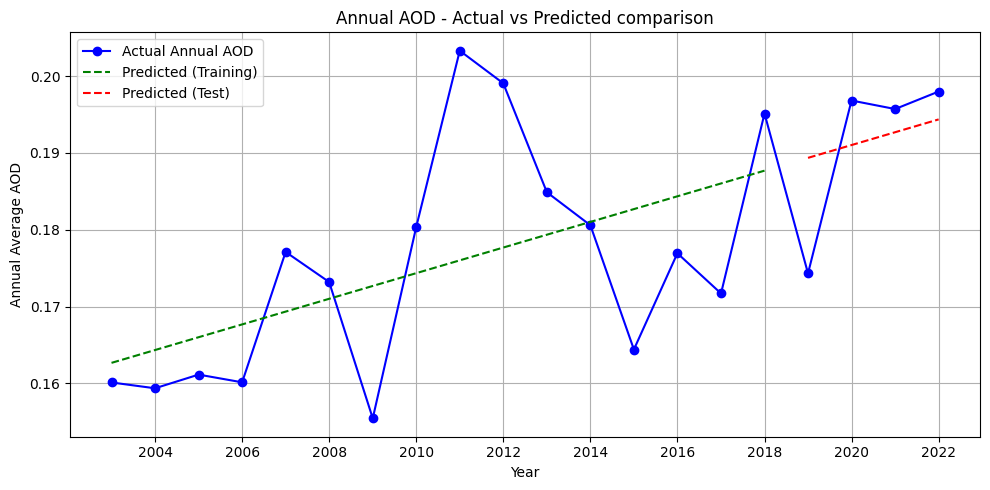

In [15]:
# Prepare features and target
X_dates = annual_avg["date_parsed"].to_numpy()
X = X_dates.astype("datetime64[D]").astype("int64").reshape(-1, 1)
y = annual_avg["annual_avg_aod"].to_numpy()

# Train-test split (using 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the full dataset with model predictions
plt.figure(figsize=(10, 5))
plt.plot(X_dates, y, label="Actual Annual AOD", marker='o', color="blue")
plt.plot(X_dates[:len(X_train)], y_train_pred, label="Predicted (Training)", linestyle='--', color="green")
plt.plot(X_dates[len(X_train):], y_test_pred, label="Predicted (Test)", linestyle='--', color="red")
plt.xlabel("Year")
plt.ylabel("Annual Average AOD")
plt.title("Annual AOD - Actual vs Predicted comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:


# Model evaluation function
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    print("-" * 30)

# Evaluate on training set
evaluate_model(y_train, y_train_pred, "Training Set")

# Evaluate on test set
evaluate_model(y_test, y_test_pred, "Test Set")


Training Set Performance:
  RMSE: 0.0122
  MAE:  0.0097
  R²:   0.2834
------------------------------
Test Set Performance:
  RMSE: 0.0084
  MAE:  0.0069
  R²:   0.2637
------------------------------
